Contributions 
==

    - k-means (bootstrap): 
        1) k
        2) k centroid placement
        -) (applicable w/w not only k-means)
    - streaming k-means (online):
        using stats if can not fit, add new `c`
    - desterministic
    
    
Random links
===
- https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
- https://github.com/demotu/BMC/blob/master/functions/detect_peaks.py
- https://cs.joensuu.fi/sipu/datasets/


In [1]:
"""
Imports
"""
%matplotlib inline
from __future__ import print_function

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from matplotlib import transforms, mlab
from itertools import groupby
from operator import itemgetter
import math
from matplotlib.patches import Ellipse
from pylab import figure
import sympy

sys.path.insert(1, r'./funcs')  # add to pythonpath

In [ ]:
# dataset generator

z = [
    np.random.normal(0,2,(100,2)),
    np.random.normal(15,3,(100,2)),
    np.random.normal(30,1,(100,2)),
]

with open('X_1.tsv', 'w+') as f:
    for a in z:
        plt.scatter(*zip(*a))
        for (x,y) in a:
            f.write('%f %f\n' % (x,y))

In [2]:
"""
Kmeans implementation
"""
import sys
import math
from collections import defaultdict
from detect_peaks import detect_peaks


def kmeans(dataset, k=None, centroids=None, e=0.01, max_iteration=20, show=False, sbs=False, DEBUG=False):  
    # --- Utils ---
    # colors = ['r','b','g','c','m','y','k']  
    colors = matplotlib.colors.cnames.values()

    def color(c):
        return colors[c%len(colors)]

    def dist(a,b):
        return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

    def generate_points(n, min_x=-5, min_y=-5, max_x=5, max_y=5):
        return [(np.random.uniform(min_x, max_x), 
                 np.random.uniform(min_y, max_y))
                for x in range(n)]

    def plot2d(data, *args, **kwargs):
        x = np.asarray([z[0] for z in data])
        y = np.asarray([z[1] for z in data])
        plt.plot(x, y,  ls='', *args, **kwargs)
    
    
    # --- Actual code ---
    x = np.asarray([z[0] for z in dataset])
    y = np.asarray([z[1] for z in dataset])
    
    if not (k or centroids):
        raise Exception('k or centroids required')
    
    if centroids:
        k = len(centroids)
    else:
        centroids = generate_points(k, min(x), min(y), max(x), max(y))
           
    # Plot initial data
    if show:
        plt.title("Initial state")
        plot2d(dataset, 'ko')
        plot2d(centroids, 'r^')
        plt.show()

    # Add id to centroids
    centroids = dict(enumerate(centroids))
    # centroids: {cid -> (x,y)}
    
    for z in xrange(max_iteration):
        # Assign clusters
        if DEBUG: print("[%d] Assigning points to centroids" % z)
        clusters = map(lambda (x,y):
                       (x, y,  min(
                           map(lambda (ci, (cx, cy)): (ci, dist((cx, cy), (x,y))), 
                               centroids.iteritems()),
                           key=lambda (ci, distance): distance)[0]
                       ),
                       dataset)
        # points -> (x,y,cid)
        
        
        # Recompute centroids
        if DEBUG: print("[%d] Recomputing centroids" % z)
        cstats = dict([(cid,(0,0,0)) for cid in centroids.keys()])
        for (x,y,c) in clusters:
            (cx, cy, n) = cstats.get(c)
            cstats[c] = (cx+x, cy+y, n+1)
         
        # Update centroids
        if DEBUG: print("[%d] Updating centroids" % z)
        new_centroids = dict((c,(x/n, y/n)) for (c, (x,y,n)) in cstats.iteritems() if n > 0)
        stop = all(map(lambda (c,(x,y)): dist(centroids.get(c), (x,y)) < e, new_centroids.iteritems())) 
        centroids = new_centroids
        
        # Plot the situation
        if show:
            print("[%d] Plotting" % z)
            plt.figure(figsize=(12,5))
            for q in xrange(k):
                plot2d(filter(lambda (x,y,c): c == q, clusters), color(q), marker='o')
            for (ci,point) in centroids.iteritems():
                plot2d([point], 'g', marker='^')
            plt.title("Iteration {}".format(z))
            plt.grid()
            plt.show()
            
        # If sbs (aka step-by-step) use generators to retrieve
        # clusters & centroids at each iteration
        if sbs:
            yield (clusters, centroids, cstats)
        if stop:
            return 

In [3]:
"""
Density functions
"""
def compute_density(serie, nbuckets=None):
    nbuckets = nbuckets or int(math.sqrt(len(serie)))
    hist_y, bins = np.histogram(serie, nbuckets, density=True)
    # take mean as point instead of boundary
    hist_x = [(bins[i] + bins[i+1])/2 for i in xrange(0, len(bins)-1)]
    return (hist_x, hist_y, nbuckets)


def plot_density(dimension, ax, rotation=0, nbuckets=None):
    # Rotation
    base = ax.transData
    rot = transforms.Affine2D().rotate_deg(rotation)

    # Compute density
    hist_x, hist_y, nbuckets = compute_density(dimension, nbuckets)
    ax.plot(hist_x, hist_y, '*', transform = rot + base)
    
    # Density interpolation
    f = interp1d(hist_x, hist_y, kind=3, assume_sorted=False)
    ax.plot(hist_x, f(hist_x), 'g--', transform = rot + base)
    
    if rotation in [0, 180]:
        ax.set_xlim([min(dimension), max(dimension)])
    else:
        ax.set_ylim([min(dimension), max(dimension)])
    return (hist_x, hist_y)

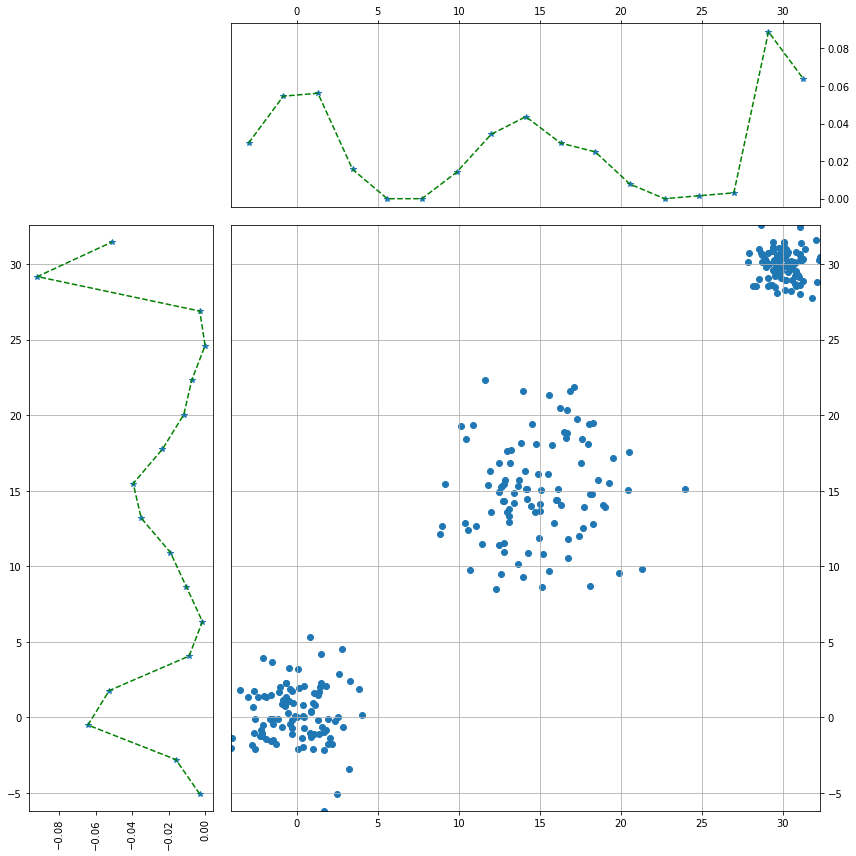

In [45]:
# import dataset
DATASETS=['g2/g2-2-100.txt', 'a1.txt', 'unbalance.txt', 'X_1.tsv']
DATASET=DATASETS[3]

with open(DATASET, 'rb') as dataset:
    points = [map(lambda z: float(z), row.strip().split()) for row in dataset]
x = np.asarray([x for x,_ in points])
y = np.asarray([y for _,y in points])
assert len(x) == len(y)


# Whole figure
plt.figure(figsize=(12,12))
# Top bar
x_density = plt.subplot2grid((4,4), (0,1), colspan=3) 
hx = plot_density(x, x_density)
x_density.tick_params(axis='x', which='both', 
                      bottom='off', top='on',  
                      labelbottom='off', labeltop='on')
x_density.tick_params(axis='y', which='both', 
                      left='off', right='on',
                      labelleft='off', labelright='on') 
plt.grid(which='major', axis='x')
# Left Bar
y_density = plt.subplot2grid((4,4), (1,0), rowspan=3) 
hy = plot_density(y, y_density, rotation=90)
y_density.tick_params(axis='x', which='both', 
                      bottom='on', top='off',  
                      labelbottom='on', labeltop='off')
plt.xticks(rotation=90)
plt.grid(which='major', axis='y')
# Actual data
data = plt.subplot2grid((4,4), (1,1), rowspan=3, colspan=3)
data.scatter(x,y)
data.tick_params(axis='y', which='both', 
                 left='off', right='on',
                 labelleft='off', labelright='on') 
data.set_ylim([min(y), max(y)])
data.set_xlim([min(x), max(x)])
plt.grid()

plt.tight_layout()
plt.show()

In [5]:
import numpy as np
from shapely.geometry.polygon import LinearRing

# https://stackoverflow.com/questions/15445546/finding-intersection-points-of-two-ellipses-python#15446492

def ellipse_polyline(x0, y0, a, b, angle=0, n=100):
    """
        a: horizzontal semi-axis (aka hradius)
        b: verital semi-axis (aka vradius)
    """
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    st = np.sin(t)
    ct = np.cos(t)

    angle = np.deg2rad(angle)
    sa = np.sin(angle)
    ca = np.cos(angle)
    p = np.empty((n, 2))
    p[:, 0] = x0 + a * ca * ct - b * sa * st
    p[:, 1] = y0 + a * sa * ct + b * ca * st
    return p

def ellipse_intersect(a, b, ret_points=False):
    ea = LinearRing(a)
    eb = LinearRing(b)
    mp = ea.intersection(eb)

    if ret_points:
        x = [p.x for p in mp]
        y = [p.y for p in mp]
        return x, y
    return bool(mp)

In [39]:
def find_ellipses(centroids, clusters):
    """
    Returns 
        [(centroid_id, ((x_mean, x_std, x_density_normalized), (y_mean, y_std, y_density_normalized)))]
    """
    
    c_density = dict()
    dmx = list()
    dmy = list()
    for (c, members) in groupby(sorted(clusters, key=itemgetter(2)), itemgetter(2)):       
        # x serie, y serie
        xs, ys, _ = zip(*members)
        
        if len(xs) == 1: continue
        
        # fitting data
        ((xmean, xvar), (ymean, yvar)) = (norm.fit(xs), norm.fit(ys))
        
        # compute density y in mean point
        dmx.append(mlab.normpdf([xmean], xmean, xvar))
        dmy.append(mlab.normpdf([ymean], ymean, yvar))
        
        # Save clusters mean and std
        c_density[c] = ((xmean, xvar), (ymean, yvar))
    
    # Compute dataset mean and std in mean points
    xm = (np.nanmean(dmx), np.nanstd(dmx))
    ym = (np.nanmean(dmy), np.nanstd(dmy))
    
    # Inject normalized density
    return dict((c, (
        (xmean, xvar, math.fabs(mlab.normpdf([xmean], xmean, xvar) - xm[0]) / xm[1]), 
        (ymean, yvar, math.fabs(mlab.normpdf([ymean], ymean, yvar) - ym[0]) / ym[1])
    )) for (c, ((xmean, xvar), (ymean, yvar))) in c_density.iteritems())
    
    
def plot_density_ellipses(density_el, sf):
    fig = figure(figsize=(20,14))
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(x,y)

    for (c, ((xmean, xvar, wx), (ymean, yvar, wy))) in  density_el.iteritems():
        loc = (xmean, ymean)
        w, h = get_el_size((c, ((xmean, xvar, wx), (ymean, yvar, wy))), sf=sf)
        ellipse = Ellipse(xy=loc, width=w, height=h, color='black') 
        ellipse.set_facecolor('none')
        ellipse.set_clip_box(ax.bbox)
        ax.add_patch(ellipse)
        ax.scatter(*loc, color='r')
    plt.show()
    
    
def get_el_size(point, sf):
    (c, ((xmean, xvar, wx), (ymean, yvar, wy))) = point
    
    return (
        ((xvar * 2 * 0.35) + (wx * 0.7)) * sf, 
        ((yvar * 2 * 0.35) + (wy * 0.7)) * sf,
    )
    
    
def find_merge_ellipses(density_el, sf):   
    # NOTE: sympy.Ellipse takes radius, matplotlib takes diameter
    merges = list()    
    density_el_lst = density_el.items()
    for i in xrange(len(density_el_lst)):
        (ic, ((ixmean, ixvar, iwx), (iymean, iyvar, iwy))) = density_el_lst[i]
        iw, ih = get_el_size(density_el_lst[i], sf)        
        ie = ellipse_polyline(ixmean, iymean, iw/2.0, ih/2.0)
        
        #print('[%d] Outer loop %d' % (i, ic))
        
        for j in xrange(i):
            (jc, ((jxmean, jxvar, jwx), (jymean, jyvar, jwy))) = density_el_lst[j]
            jw, jh = get_el_size(density_el_lst[j], sf)
            
            #print('\t[%d %d] Inner loop  %d' % (i, j, jc))
            
            je = ellipse_polyline(jxmean, jymean, jw/2.0, jh/2.0)
            
            #print('\t\t[%d, %d] Comparing %d vs %d' % (i,j,ic,jc))
            if ellipse_intersect(ie,je):
                #print("\t\t\t[%d, %d] Merging %d <- %d" % (i,j,ic,jc))
                merges.append((ic, jc,))
    return merges


def apply_merge_startegy(cstats, merges):
    """
    Arguments:
        cstats: {c: (xsum, ysum, n)}
        merges: [(c1, c2)]
    Returns:
        centroids, cstats
    """
    
    #print("cstats:", cstats)
    print("merges:", merges)
    
    def find_current_group(c):
        if cstats[c]:
            return c
        return find_current_group(merged[c])
    
    merged = dict()    
    # Apply merges
    for (c1, c2) in merges:
        # merge 1 <-- 2
        
        #print('Find groups', c1, c2)
        c1 = find_current_group(c1)
        c2 = find_current_group(c2)
        if c1 == c2: 
            continue
        
        c1_xsum, c1_ysum, c1_n = cstats[c1]
        c2_xsum, c2_ysum, c2_n = cstats[c2]
        
        #print('join groups', c1, c2)
        cstats[c1] = (c1_xsum + c2_xsum, c1_ysum + c2_ysum, c1_n + c2_n)
        merged[c2] = c1
        cstats[c2] = None
    
    print('Compute centroids')
    
    # Recompute centroids
    return [(x/n, y/n) for (c, (x,y,n)) in 
            filter(lambda (c, z): z is not None, cstats.iteritems()) if n > 0]

........_

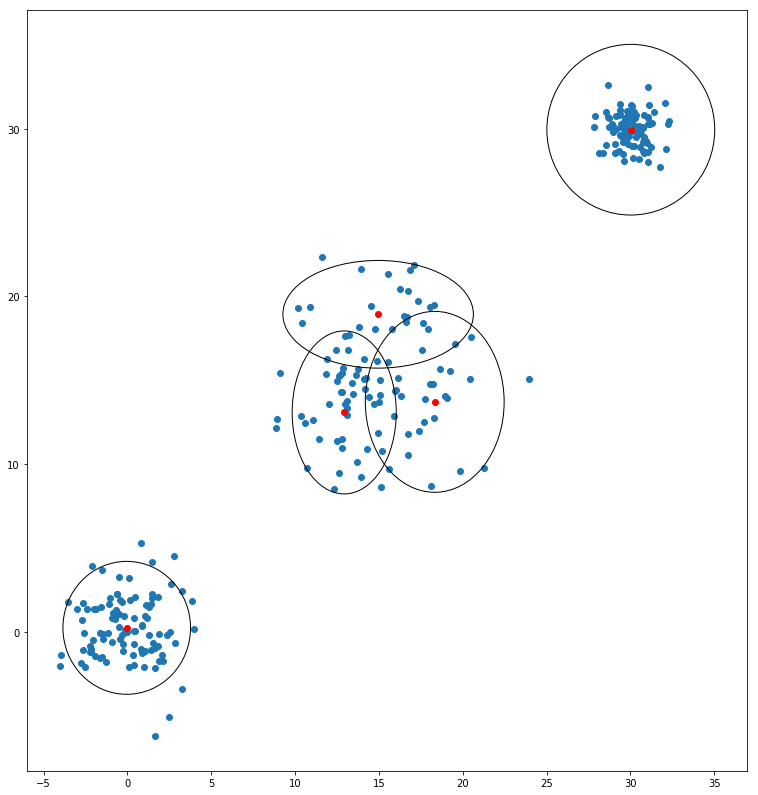

__merges: [(5, 4), (7, 4), (7, 5)]
Compute centroids
_._

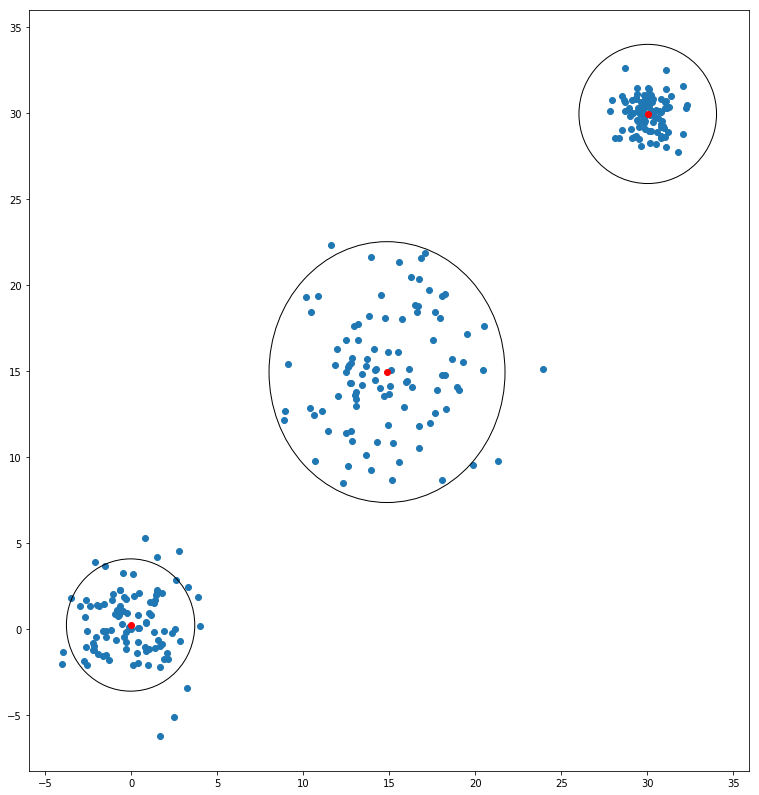

__merges: []
Compute centroids
_._

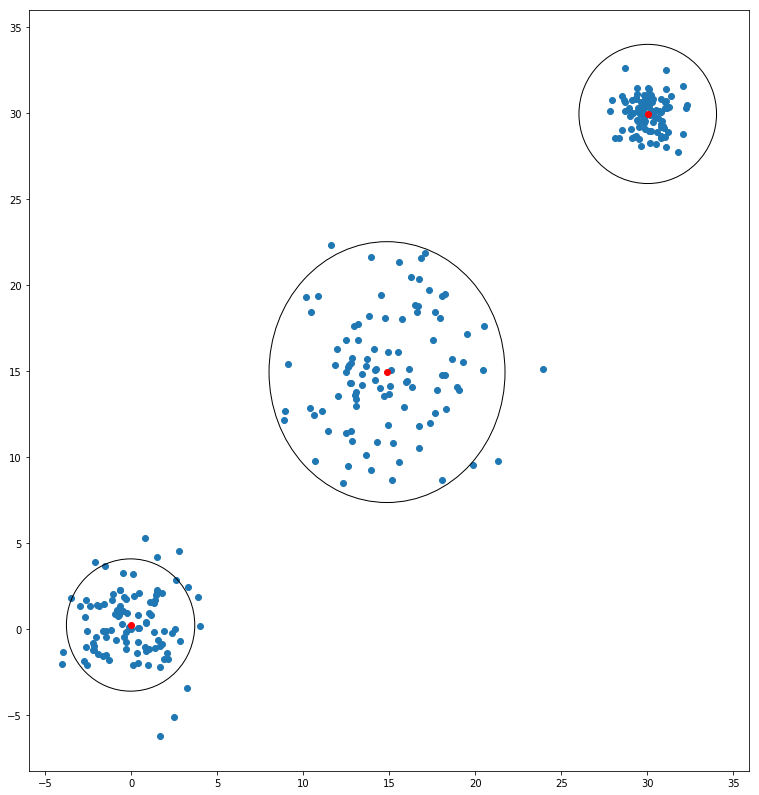

__merges: []
Compute centroids
_._

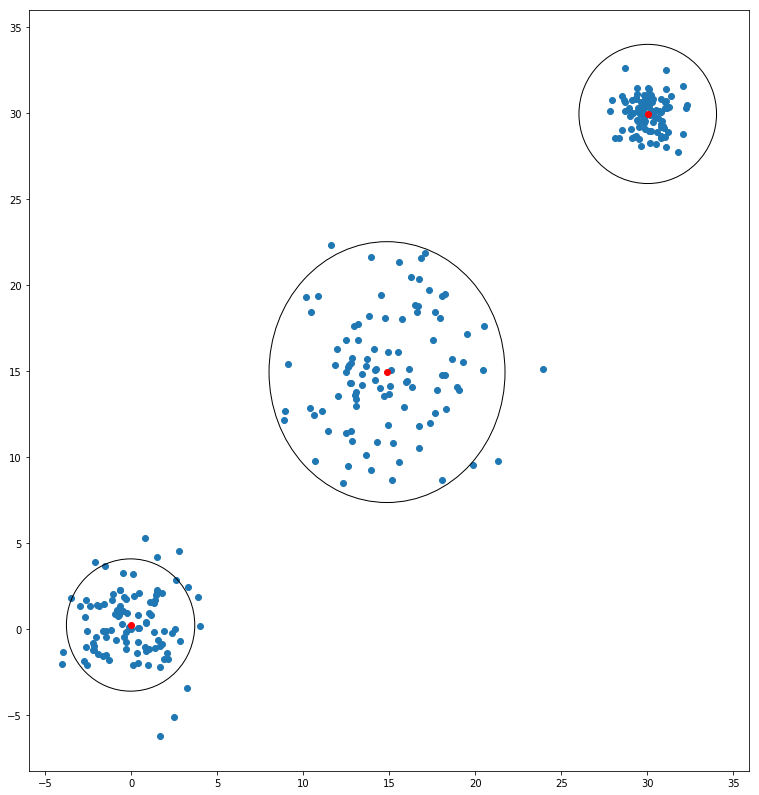

__merges: []
Compute centroids
_._

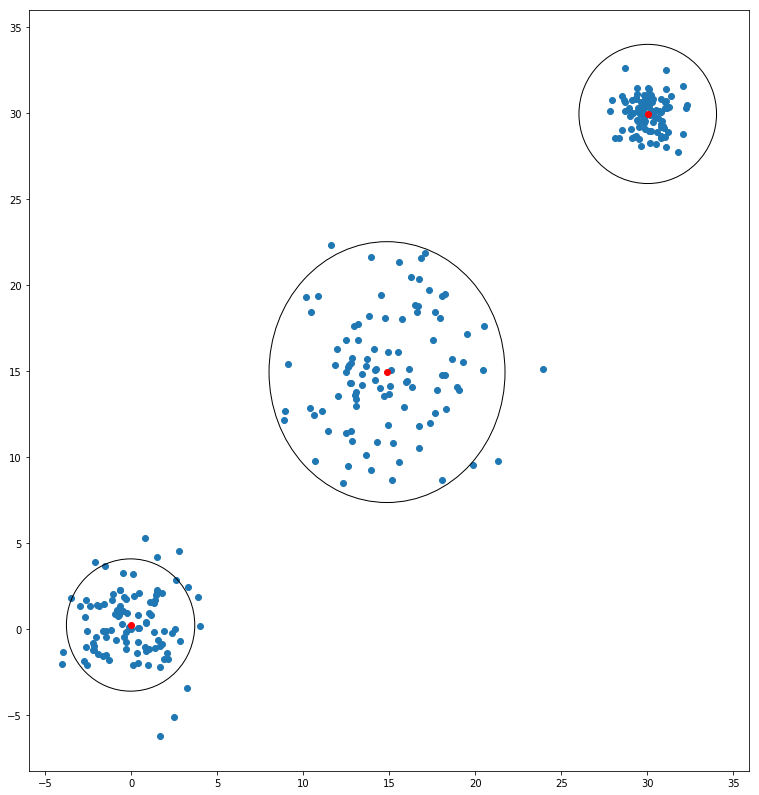

__merges: []
Compute centroids
_._

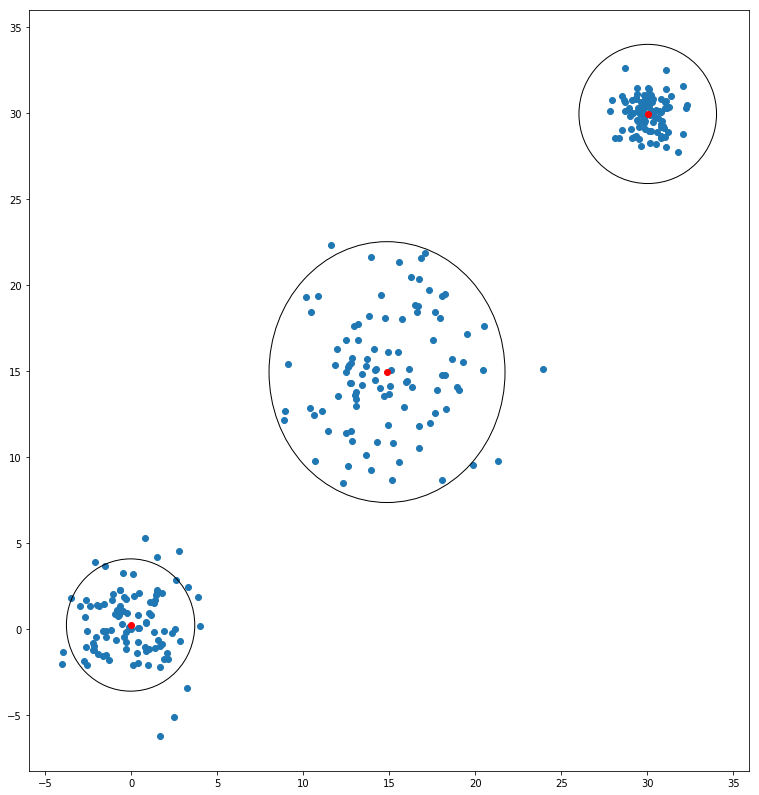

__merges: []
Compute centroids
_._

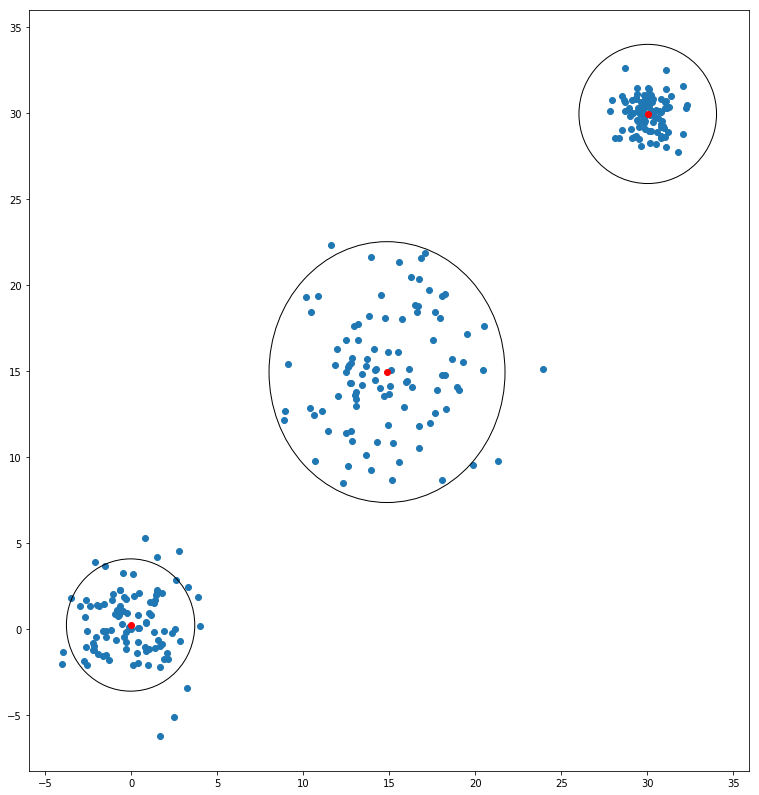

__merges: []
Compute centroids
_._

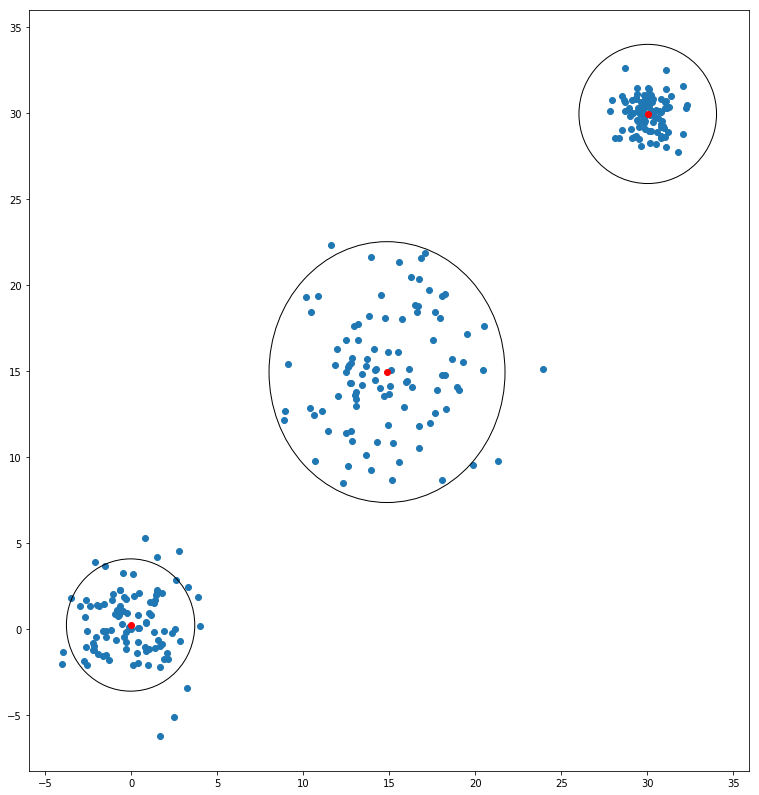

__merges: []
Compute centroids
_._

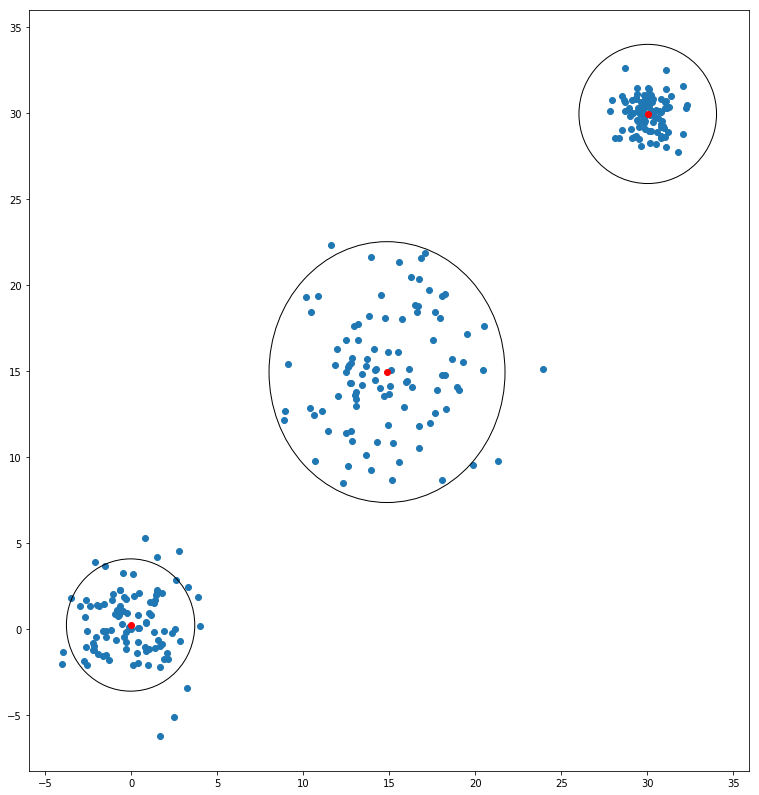

__merges: []
Compute centroids
_._

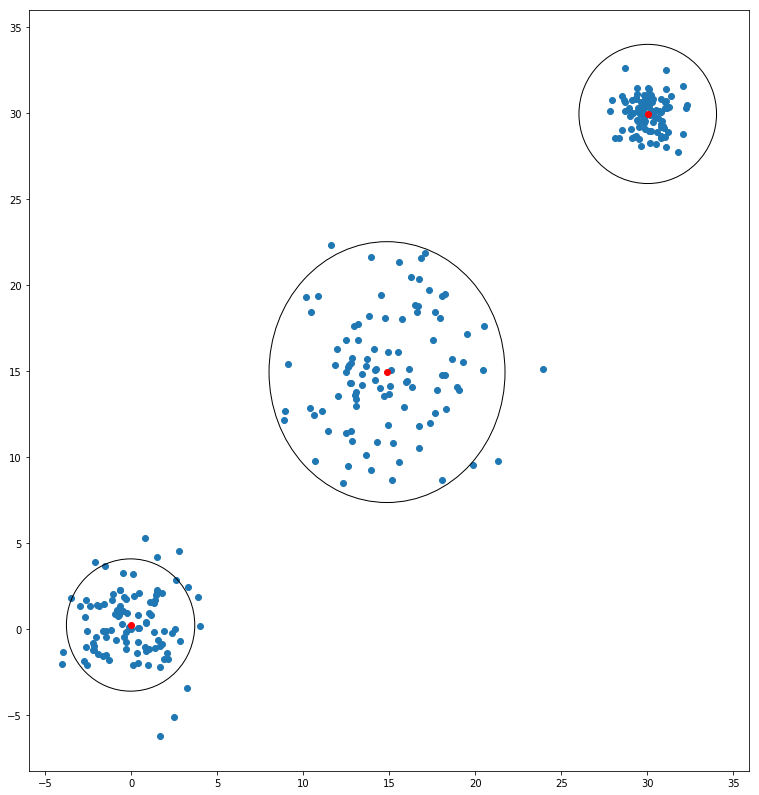

__merges: []
Compute centroids
_

In [46]:
# Phase 1: K-Means bootstrap // detecting peaks
px = detect_peaks(hx[1], show=False)
py = detect_peaks(hy[1], show=False)
p_matrix = [(hx[0][x1], hy[0][y1])  for x1 in px for y1 in py]

SF=5

centroids = p_matrix
for i in xrange(10):   
    for clusters, centroids, cstats in kmeans(points, centroids=centroids, max_iteration=10, show=False, sbs=True): 
        print(".", end="")

    density_el = find_ellipses(centroids, clusters)
    print("_", end="")
    plot_density_ellipses(density_el, SF)
    print("_", end="")
    merges = find_merge_ellipses(density_el, SF)
    print("_", end="")
    centroids = apply_merge_startegy(cstats, merges)
    print("_", end="")